In [3]:
import cv2
import os
from time import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people

DATASET

In [4]:
#Download the LFW_people's dataset
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4) 
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1] 

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0] 

# Dataset Details
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes) 

Number of Data Samples:  1288
Size of a data sample:  1850
Number of Class Labels:  7


In [5]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


EXPLORING DATASET

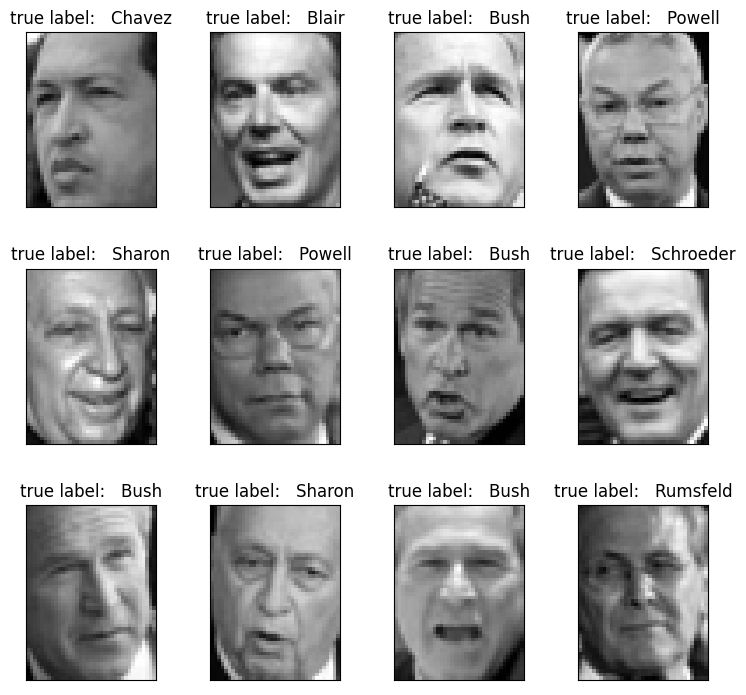

In [6]:
#Plotting images in 4 col * 3 rows
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())

#labels for images
def true_title(Y, target_names, i):
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
    return 'true label:   % s' % (true_name)
 
true_titles = [true_title(y, target_names, i)
                     for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)

SPLITTING DATASET

In [7]:
#Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)
print("size of training Data is % d and Testing Data is % d" %(
        y_train.shape[0], y_test.shape[0]))

size of training Data is  966 and Testing Data is  322


IMPLEMENTING Principal Component Analysis(PCA) :

In [8]:
n_components = 150
 
t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
          whiten = True).fit(X_train)
print("done in % 0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
 
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in % 0.3fs" % (time() - t0))

done in  0.854s
Projecting the input data on the eigenfaces orthonormal basis
done in  0.008s


In [9]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimesnsions of training set = % s and Test Set = % s"%(
        X_train.shape, X_test.shape))

Sample Data point after applying PCA
 [-1.34971416e+00 -1.01670325e+00  1.77009308e+00  5.38253367e-01
 -8.99648905e-01 -4.25231159e-01 -9.11528647e-01  9.90224838e-01
  4.92789835e-01 -4.86151949e-02  4.28185984e-02  5.75878680e-01
  2.45917961e-01 -4.31920541e-03  2.77396989e+00 -3.74719918e-01
 -1.60685992e+00 -2.77524734e+00  3.97341347e+00 -1.28512740e+00
  1.21269248e-01  2.37066578e-02 -9.60395336e-01 -3.21866721e-01
  3.53265703e-01  1.29797256e+00  3.34888458e-01 -9.99598429e-02
  2.63019156e+00  1.19462991e+00  8.73623967e-01  1.05609812e-01
 -7.64846802e-01  2.11506224e+00  1.33597565e+00 -1.09949422e+00
  3.58552128e-01  2.23081303e+00 -5.17639279e-01 -1.77234995e+00
 -6.69605494e-01 -4.96724337e-01  1.18898380e+00 -2.20422834e-01
 -1.95685506e+00  1.16991615e+00 -7.85141110e-01 -8.96102309e-01
  2.17318773e+00  1.93305826e+00  4.45377302e+00 -8.16185251e-02
  1.55963826e+00  2.14753461e+00 -1.09971845e+00 -1.69055372e-01
 -1.58406532e+00  1.25180376e+00  1.33707032e-01 -9.

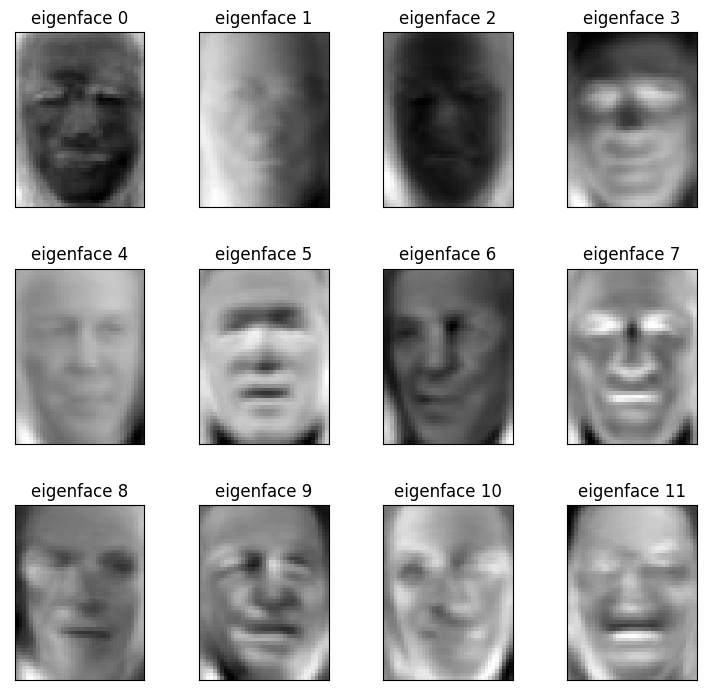

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

GRID SEARCH ALGORITHM :

In [11]:
#Applying Grid Search Algorithm 

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in % 0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
 
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in % 0.3fs" % (time() - t0))

# print classification results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Fitting the classifier to the training set
done in  11.252s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in  0.033s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.88      0.85        60
  Donald Rumsfeld       0.95      0.67      0.78        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       1.00      0.80      0.89        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.86       322
        macro avg       0.91      0.73      0.80       322
     weighted avg       0.87      0.86      0.85       322

Confusion Matrix is:
[[  7   1   0   5   0   0   0]
 [  2  53   0   5   0   0   0]
 [  0   1  18   8   0   0   0]
 [  0   3   0 143   0   0  

VISUALIZING THE RESULTS :

In [12]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


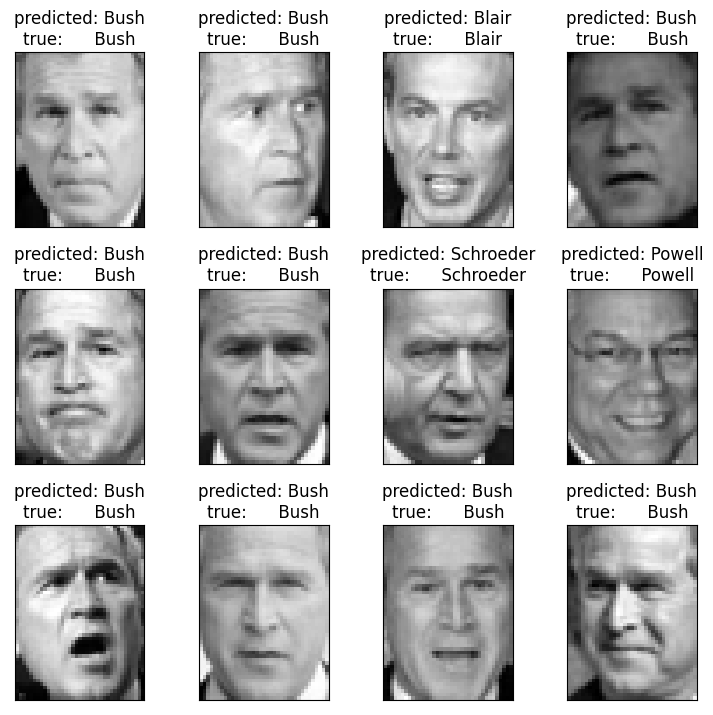

In [12]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)